In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import statsmodels
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt  
from scipy import fft as fourier
from scipy import stats
import matplotlib.pyplot as plt
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

In [215]:
path = f'{workspace}tesis/datos/'
altura_rio_file = 'procesados/datosAlturaDeRio_sorted_true.nc'

In [216]:
ds_altura = xr.open_dataset(path+altura_rio_file, engine='netcdf4')

In [217]:
santotome = pd.DataFrame(ds_altura.santotome, index=ds_altura.time)
santotome.isna().sum()

0    82
dtype: int64

In [218]:
santotome.rename(columns={'0':'altura_rio'})

,0
2007-01-01,NaN
2007-01-02,3.82
2007-01-03,3.81
2007-01-04,3.80
2007-01-05,3.79
...,...
2019-04-26,3.99
2019-04-27,4.01
2019-04-28,4.06
2019-04-29,4.07


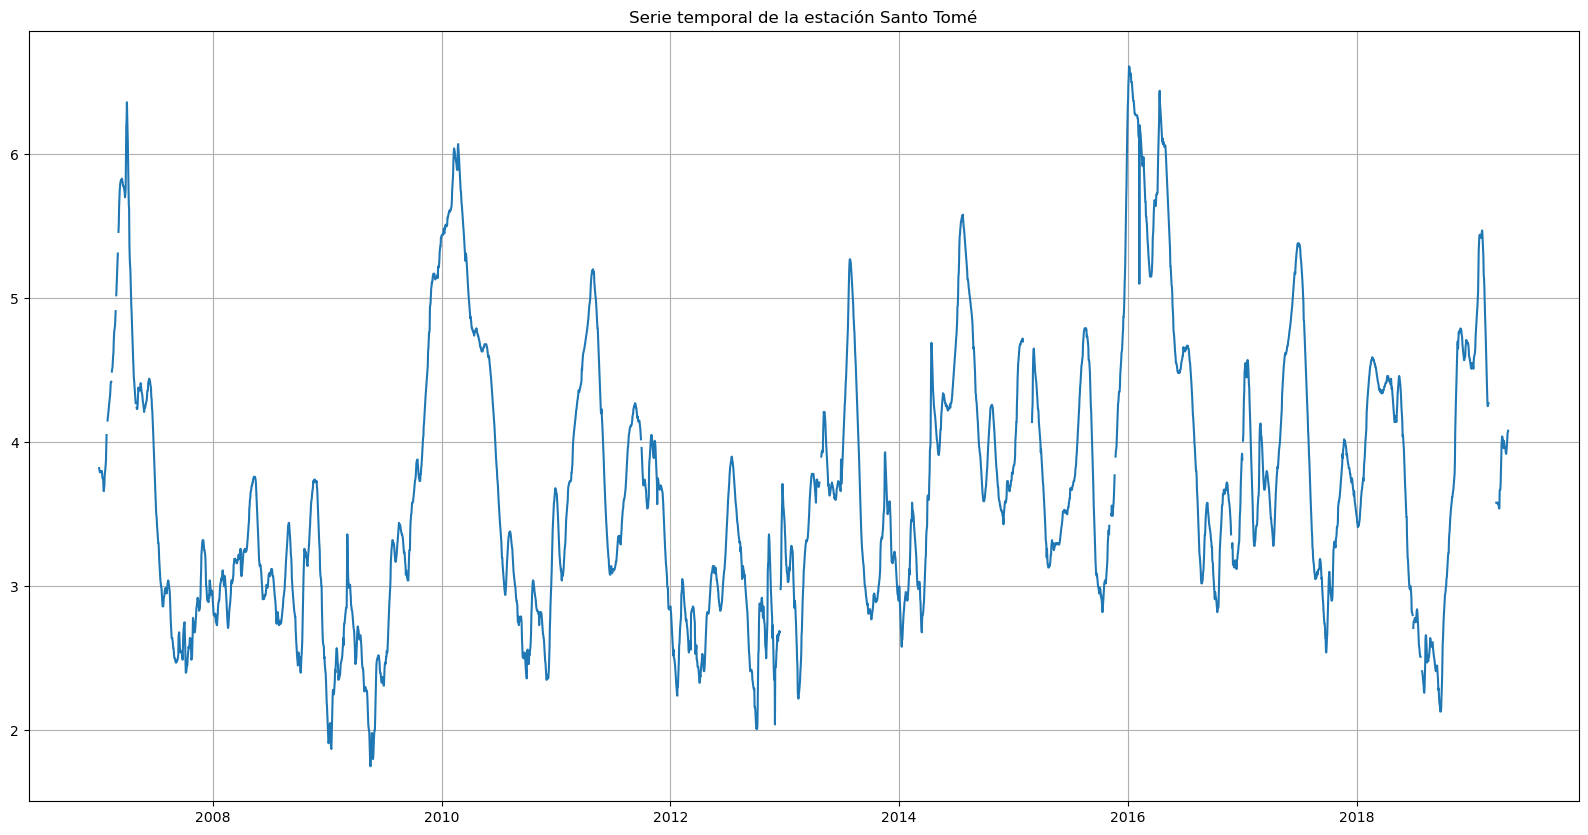

In [219]:
plt.figure(figsize=(20,10))
ax = plt.plot(santotome)
plt.title('Serie temporal de la estación Santo Tomé')
plt.grid()

In [220]:
santotome.columns = ['altura_rio']

In [221]:
santotome.backfill(inplace=True)

<AxesSubplot:>

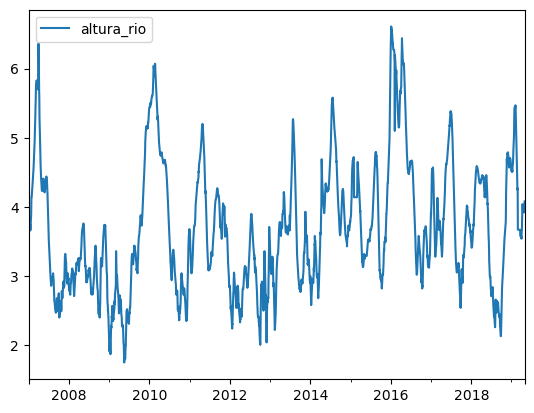

In [222]:
santotome.plot()

In [223]:
transformada = fourier.fft(santotome)
amp = abs(transformada)
freq = fourier.fftfreq(len(santotome))

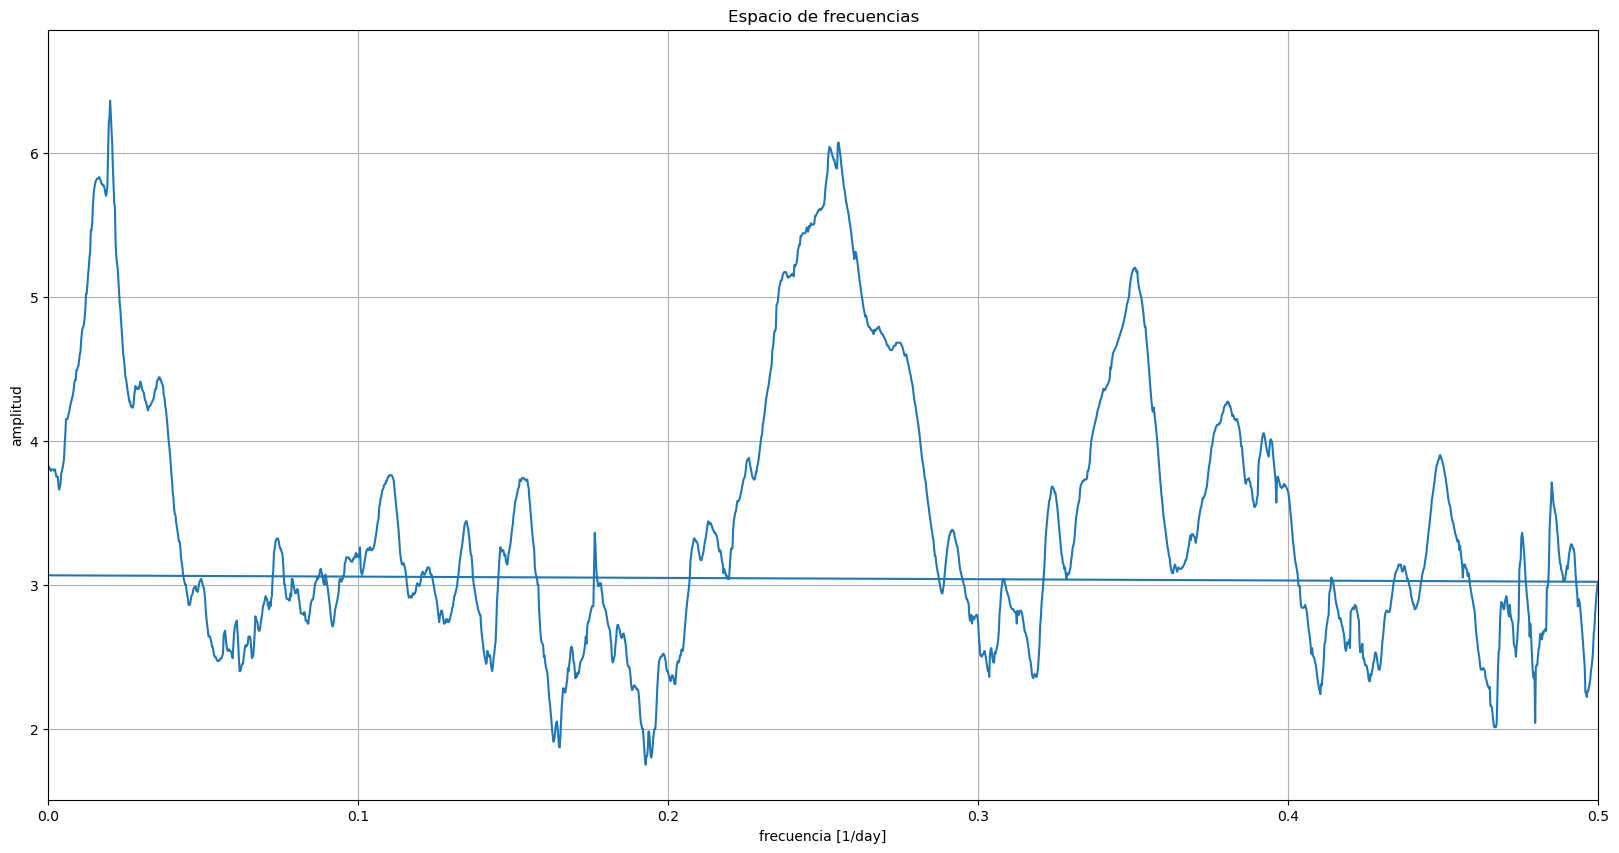

In [224]:
plt.figure(figsize=(20,10))
plt.plot(freq, amp)
plt.xlabel('frecuencia [1/day]')
plt.ylabel('amplitud')
plt.xlim(0,0.5)
plt.title('Espacio de frecuencias')
plt.grid()

In [225]:
info = pd.concat([pd.DataFrame(freq),pd.DataFrame(amp)], axis=1)
info.columns = ['freq', 'amp']
info_1 = info[info['freq']>=0].copy()
info_1[info_1['amp'] == info_1['amp'].max()]['freq']

90    0.019987
Name: freq, dtype: float64

In [226]:
(0.019987)**(-1)

50.03252113874018

# Me fijo si la serie tiene una tendencia significativa

In [227]:
import utils.mannkendall as mk

"""
And all Mann-Kendall tests return a named tuple which contained:

trend: tells the trend (increasing, decreasing or no trend)
h: True (if trend is present) or False (if the trend is absence)
p: p-value of the significance test
z: normalized test statistics
Tau: Kendall Tau
s: Mann-Kendal's score
var_s: Variance S
slope: Theil-Sen estimator/slope
intercept: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step
sen's slope function required data vector. seasonal sen's slope also has optional input period, which by the default value is 12. Both sen's slope function return only slope value.
"""

#Hago un test de Mann kendall para ver si tiene una parte determinística.

alpha_mk=0.05
resultado_mk = mk.original_test(santotome.altura_rio, alpha=alpha_mk)
print(f'se concluye que se rechaza la hipotesis nula, en favor de la alternativa con una sifnificancia del 5%: Tendencia = {resultado_mk[1]}, (p-value = {resultado_mk[2]}) con alpha de {alpha_mk}')

se concluye que se rechaza la hipotesis nula, en favor de la alternativa con una sifnificancia del 5%: Tendencia = True, (p-value = 0.0) con alpha de 0.05


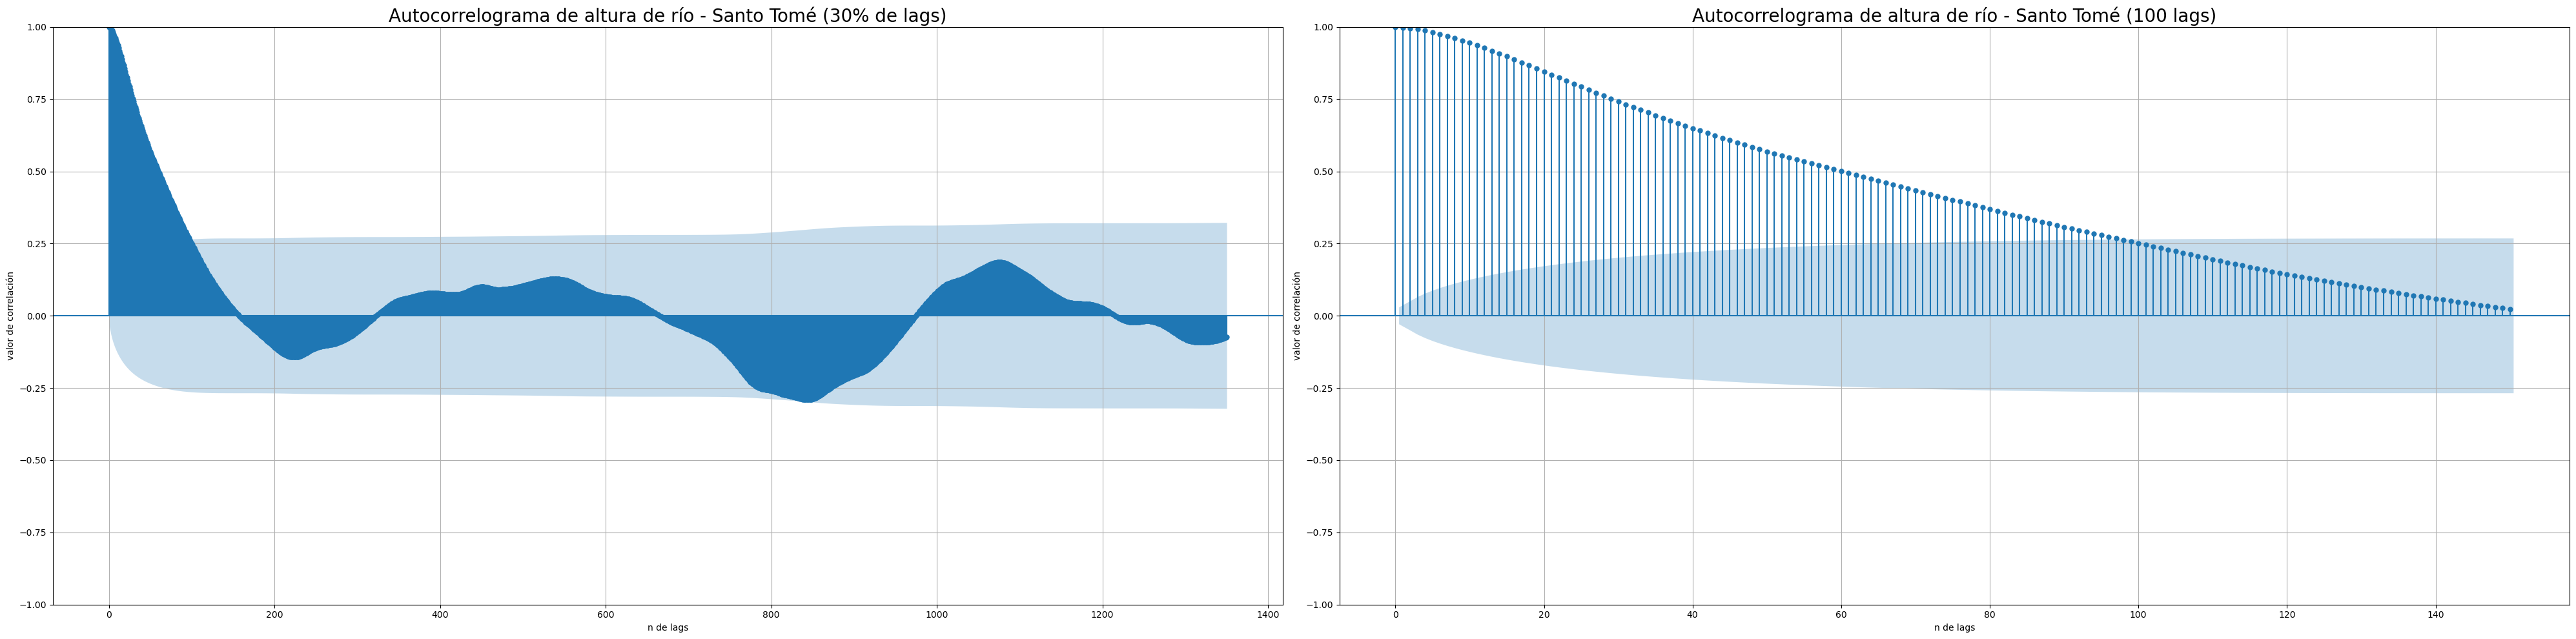

In [228]:
ax1 = plt.subplot(1,2,1)
sgt.plot_acf(santotome.altura_rio, lags = len(santotome.altura_rio)*0.3, ax=ax1)
plt.title('Autocorrelograma de altura de río - Santo Tomé (30% de lags)', size=20)
plt.xlabel('n de lags')
plt.ylabel('valor de correlación')
plt.grid()
ax2=plt.subplot(1,2,2)
sgt.plot_acf(santotome.altura_rio, lags = 150, ax=ax2).set_size_inches(40,10)
plt.title('Autocorrelograma de altura de río - Santo Tomé (100 lags)', size=20)
plt.xlabel('n de lags')
plt.ylabel('valor de correlación')
plt.grid()
plt.tight_layout()
plt.show()

In [229]:
rl = stats.linregress(y=santotome.altura_rio, x=np.arange(len(santotome)), alternative='two-sided')

In [230]:
rl

LinregressResult(slope=0.00015829346164588192, intercept=3.3354802186345864, rvalue=0.2217902171939126, pvalue=2.6700063343165473e-51, stderr=1.0373199934057685e-05, intercept_stderr=0.026963839124709916)

In [231]:
x = np.arange(len(santotome))
y = rl[0]*x + rl[1]

In [232]:
regresion_lineal = pd.DataFrame({'rl':y}, index=santotome.index)

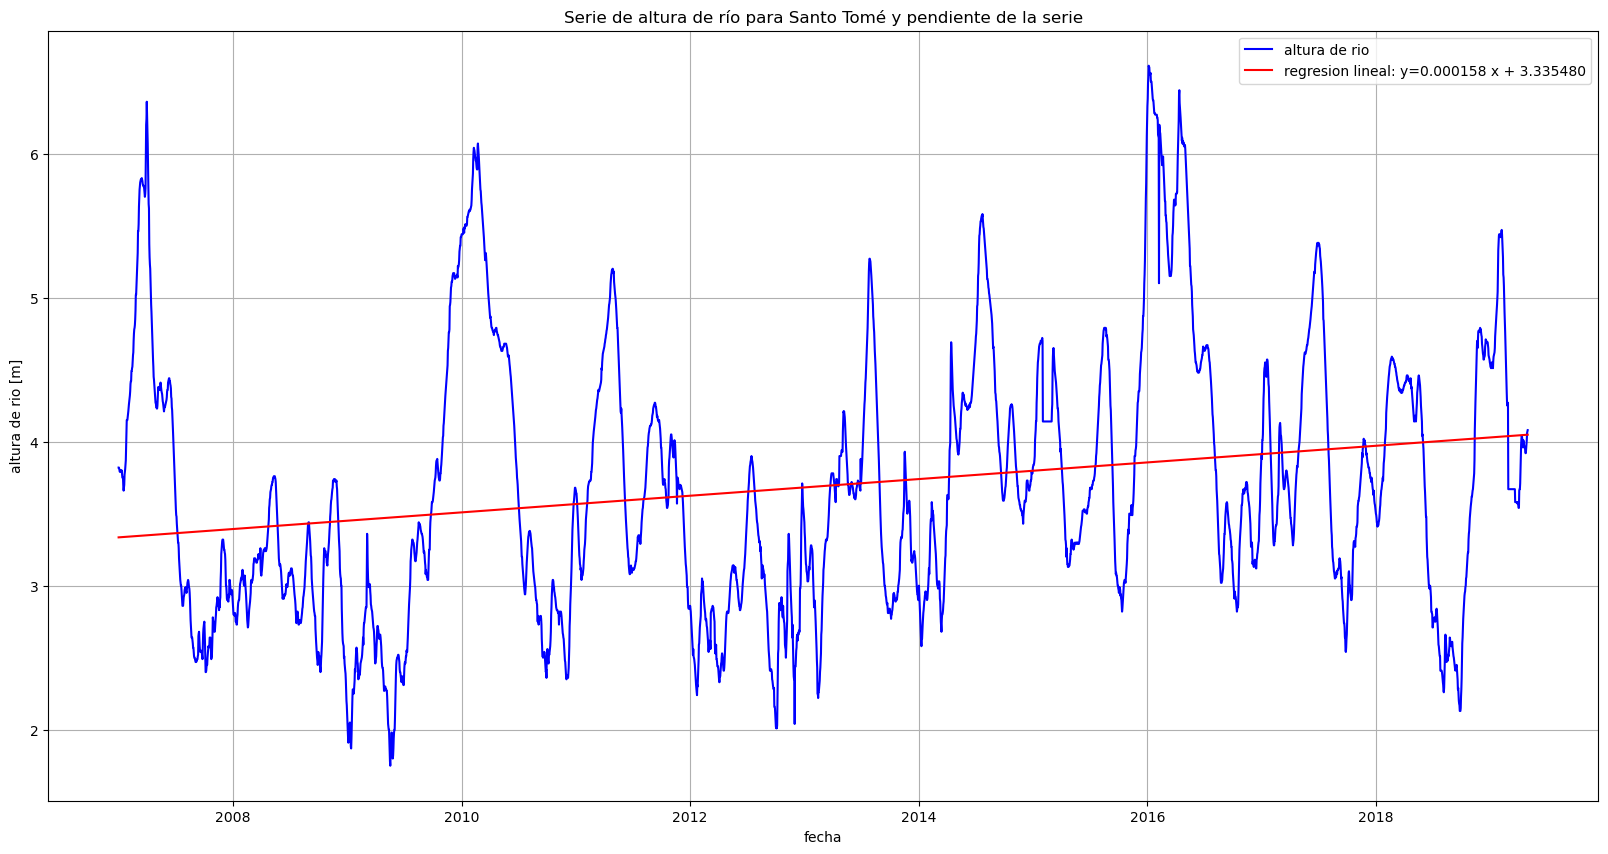

In [233]:
plt.figure(figsize=(20,10))

plt.plot(santotome, c='b', label='altura de rio')
plt.plot(regresion_lineal, c='r', label=f'regresion lineal: y={rl[0]:.6f} x + {rl[1]:.6f}')
plt.xlabel('fecha')
plt.ylabel('altura de rio [m]')
plt.grid()
plt.title('Serie de altura de río para Santo Tomé y pendiente de la serie')
plt.legend()

### Resultado del test de pendiente:

La recta resultante de la regresión lineal por mínimos cuadrados es: y = x * 0.00015829346164588192 + 3.3354802186345864. Y testeando con un test de Wald, cuya hipótesis nula es que el valor de la pendiente es 0 (cero), con un 5% de significancia. 

El p-valor es de: 2.6700063343165473e-51, por lo que se rechaza la hipótesis nula en favor de la alternativa, que la pendiente es distinta de cero. (two-sided: the slope of the regression line is nonzero).  
Como no es nula la tendencia, la filtro para poder realizar un análisis armónico.

In [234]:
santotome_sin_tendencia = santotome.altura_rio - regresion_lineal.rl

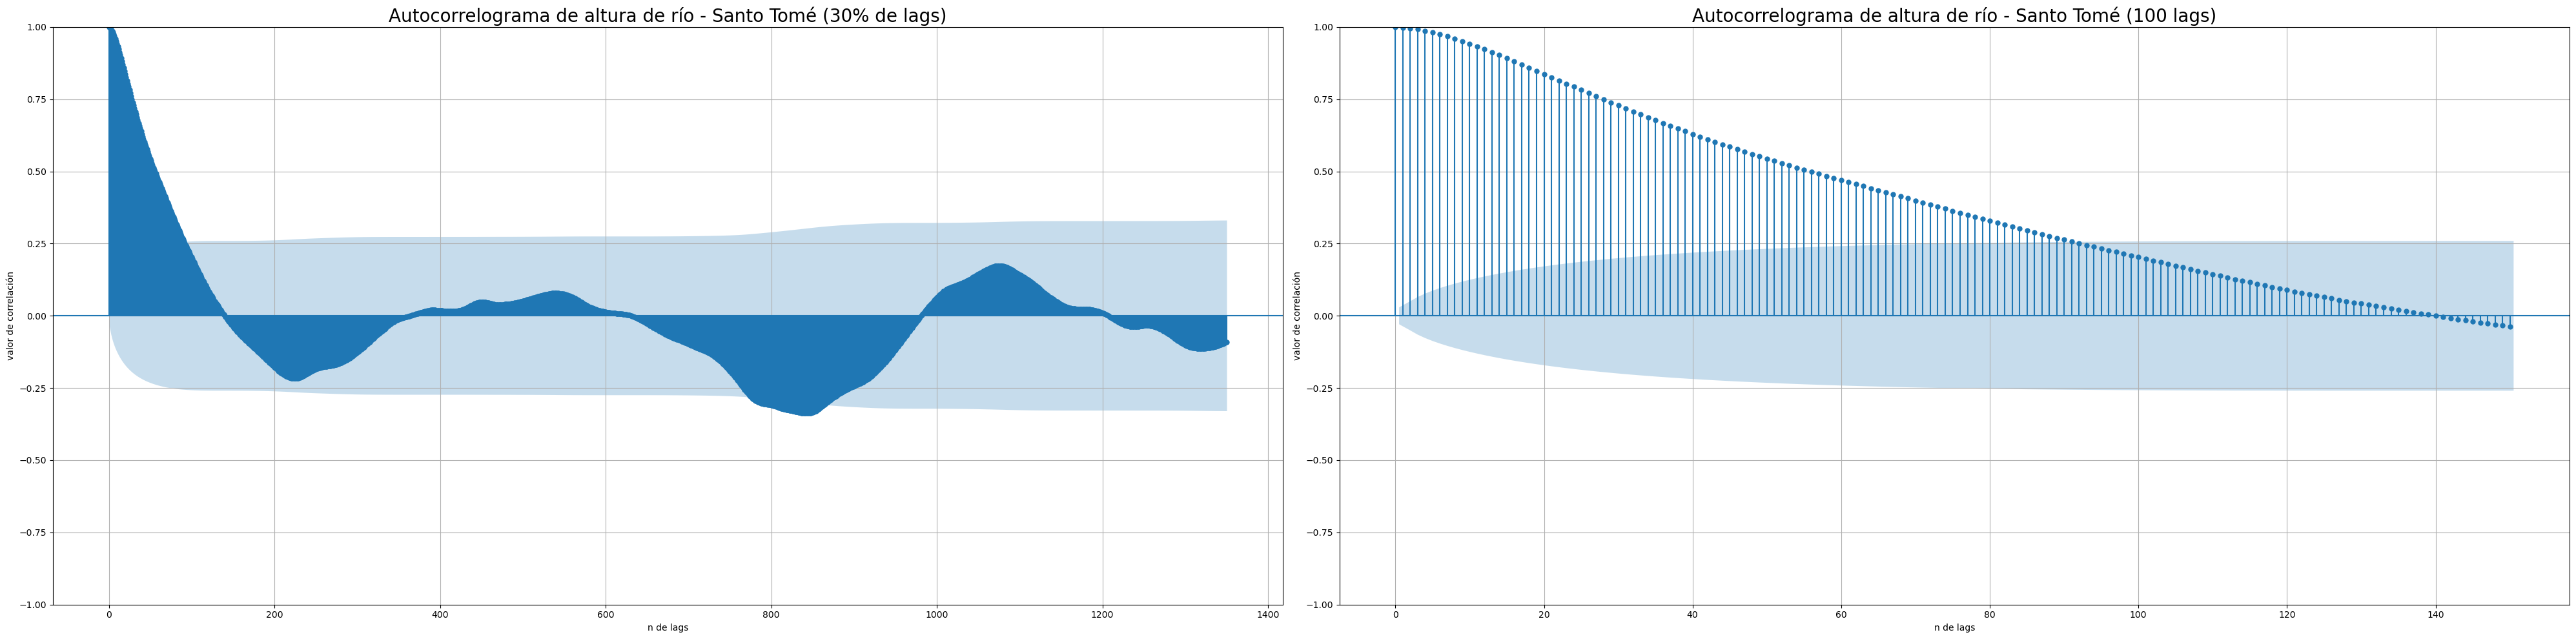

In [235]:
ax1 = plt.subplot(1,2,1)
sgt.plot_acf(santotome_sin_tendencia, lags = len(santotome_sin_tendencia)*0.3, ax=ax1)
plt.title('Autocorrelograma de altura de río - Santo Tomé (30% de lags)', size=20)
plt.xlabel('n de lags')
plt.ylabel('valor de correlación')
plt.grid()
ax2=plt.subplot(1,2,2)
sgt.plot_acf(santotome_sin_tendencia, lags = 150, ax=ax2).set_size_inches(40,10)
plt.title('Autocorrelograma de altura de río - Santo Tomé (100 lags)', size=20)
plt.xlabel('n de lags')
plt.ylabel('valor de correlación')
plt.grid()
plt.tight_layout()
plt.show()

Text(0, 0.5, 'altura de río [m]')

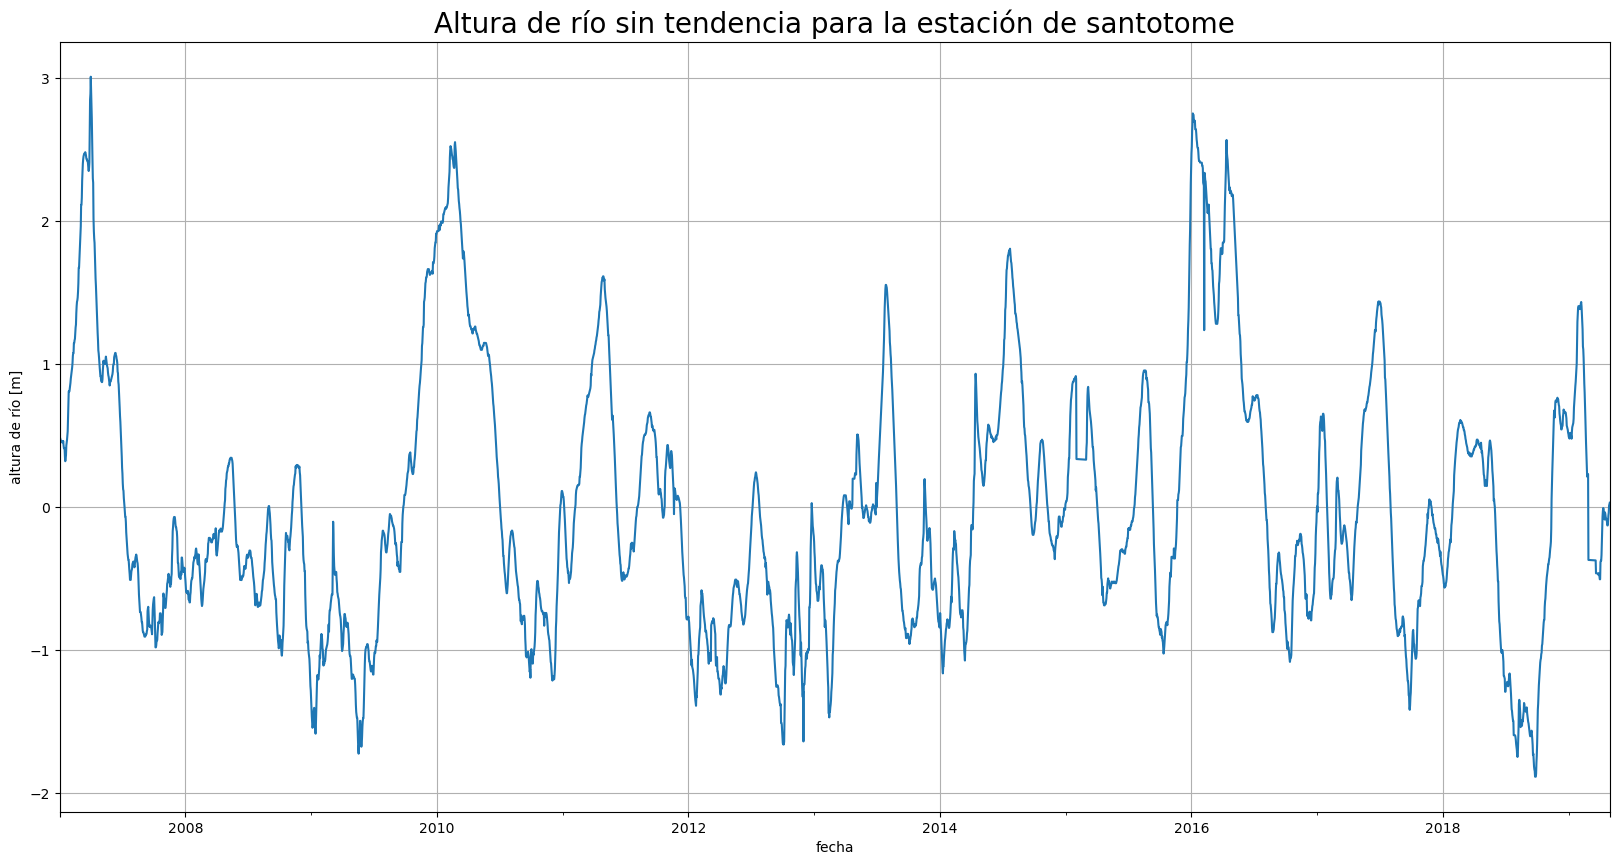

In [236]:
plt.figure(figsize=(20,10))
santotome_sin_tendencia.plot()
plt.grid()
plt.title('Altura de río sin tendencia para la estación de santotome', size=20)
plt.xlabel('fecha')
plt.ylabel('altura de río [m]')

In [237]:
1/(len(santotome_sin_tendencia)-1)

0.0002221235006663705

In [238]:
# Prueba

ft = np.fft.rfft(santotome_sin_tendencia[:-1]*np.hanning(len(santotome_sin_tendencia[:-1])), len(santotome_sin_tendencia[:-1]/2))
mgft = abs(ft)
xVals = np.fft.fftfreq(len(santotome_sin_tendencia[:-1]), d=1.0) # in days, or d=1.0/24 in days

In [239]:
freq_abs = pd.DataFrame({'freq': xVals[:len(mgft)],
             'abs':mgft})

freq_abs['var'] = (((freq_abs['abs']**2)/2)/(santotome_sin_tendencia.var()))*100


freq_abs

,freq,abs,var
0,0.000000,41.164806,1.035067e+05
1,0.000222,271.548649,4.504138e+06
2,0.000444,550.654102,1.852142e+07
3,0.000666,409.912827,1.026359e+07
4,0.000888,224.541818,3.079717e+06
...,...,...,...
2247,0.499112,1.337919,1.093392e+02
2248,0.499334,1.021042,6.368011e+01
2249,0.499556,1.030358,6.484740e+01
2250,0.499778,1.634763,1.632397e+02


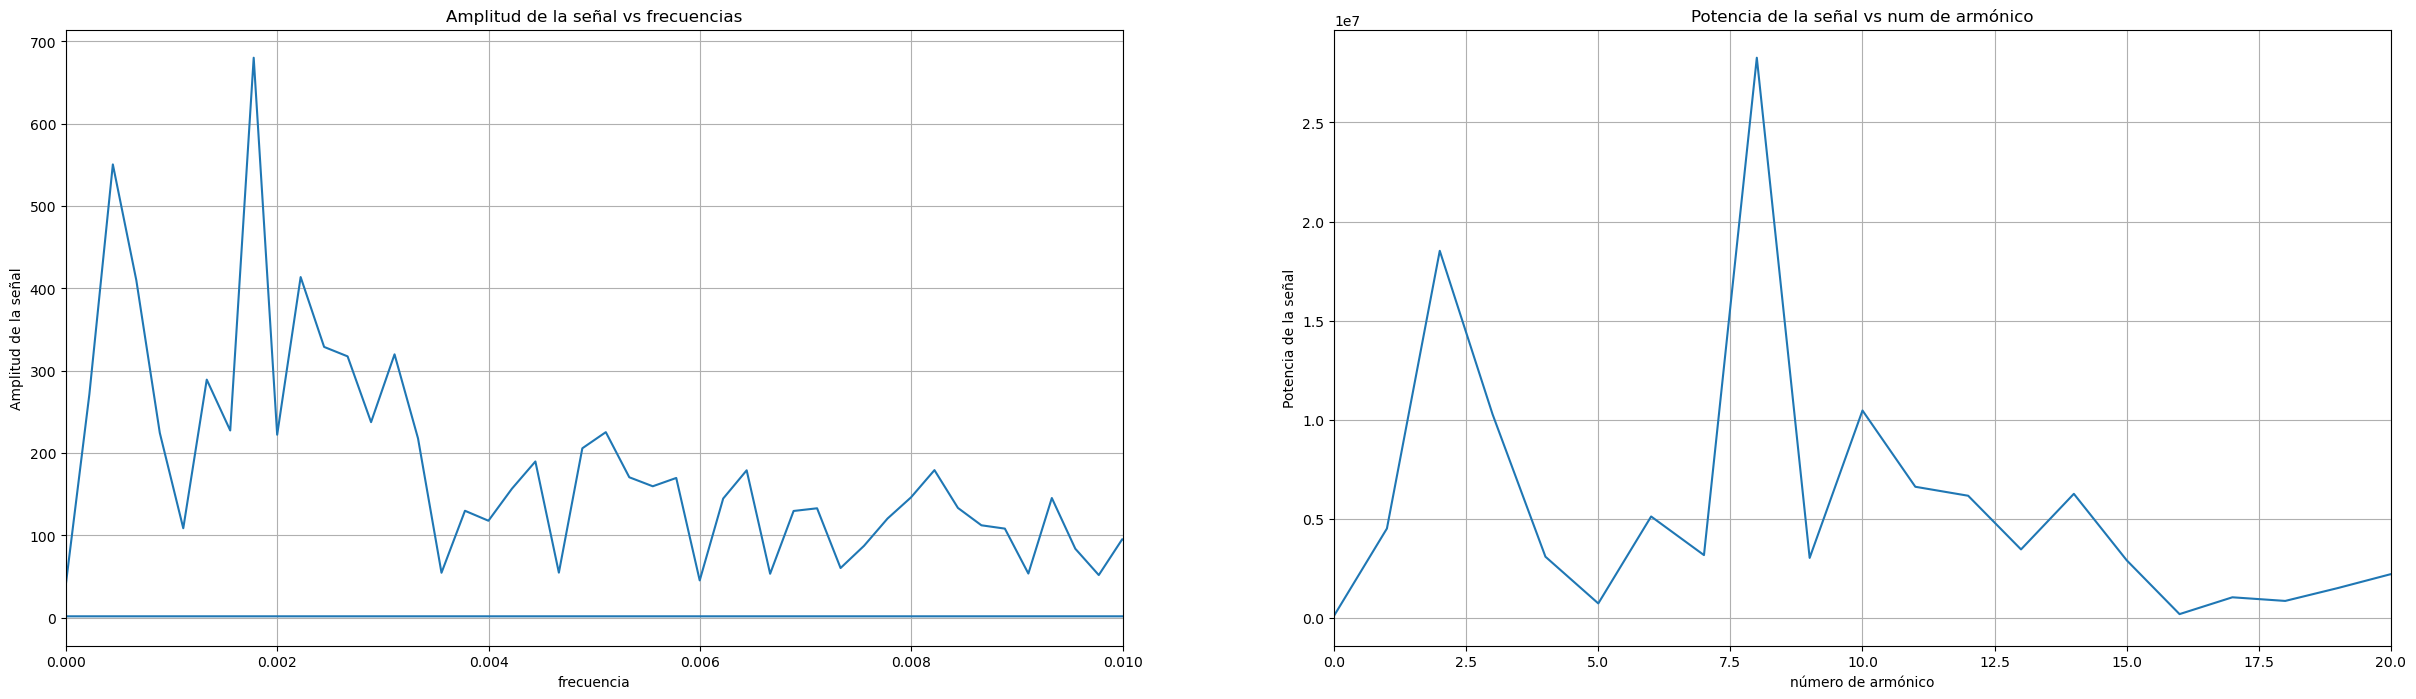

In [246]:
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.plot(xVals[:len(mgft)], mgft)
plt.xlim(0,0.01)
plt.title('Amplitud de la señal vs frecuencias')
plt.xlabel('frecuencia')
plt.ylabel('Amplitud de la señal')
plt.grid()
plt.subplot(1,2,2)
plt.plot(freq_abs['var'])
plt.title('Potencia de la señal vs num de armónico')
plt.xlabel('número de armónico')
plt.ylabel('Potencia de la señal')
plt.xlim(0,20)
plt.grid()

In [241]:
freq_abs[freq_abs['abs'] == freq_abs['abs'].max()]

,freq,abs,var
8,0.001777,680.285637,2.826826e+07


In [242]:
len(santotome_sin_tendencia[:-1])/8

562.75

In [243]:
valor = santotome_sin_tendencia[:-1]
N  =  len(valor)
K = N/2
P = N	

########CAMBIAR EL N?MERO DE ARMONICO
M = 8 #ESTE VALOR HAY QUE CAMBIAR (el armónico que quiero filtrar)

###       Calcula el promedio

PROM = valor.mean()  

PI = 3.1415926

########### comienza!
##busco los coef A y B del armónico a filtrar

SUM = 0
SAM = 0

for J in np.arange(N): 
    SUM = SUM+valor[J]*np.sin(M*2*PI*(J+1)/P)
    SAM = SAM+valor[J]*np.cos(M*2*PI*(J+1)/P)

A = 2*SUM/N
B = 2*SAM/N

XS = np.zeros(N)
FIL = np.zeros(N)


for J in np.arange(N): 
    XS[J] = A*np.sin(2*PI*M*J/P)+B*np.cos(2*PI*M*J/P)


for I in np.arange(N): 
    FIL[I]= valor[I]-XS[I]

    
resultado = pd.DataFrame({'original':valor,
             'armonico':XS,
             'filtrado':FIL})

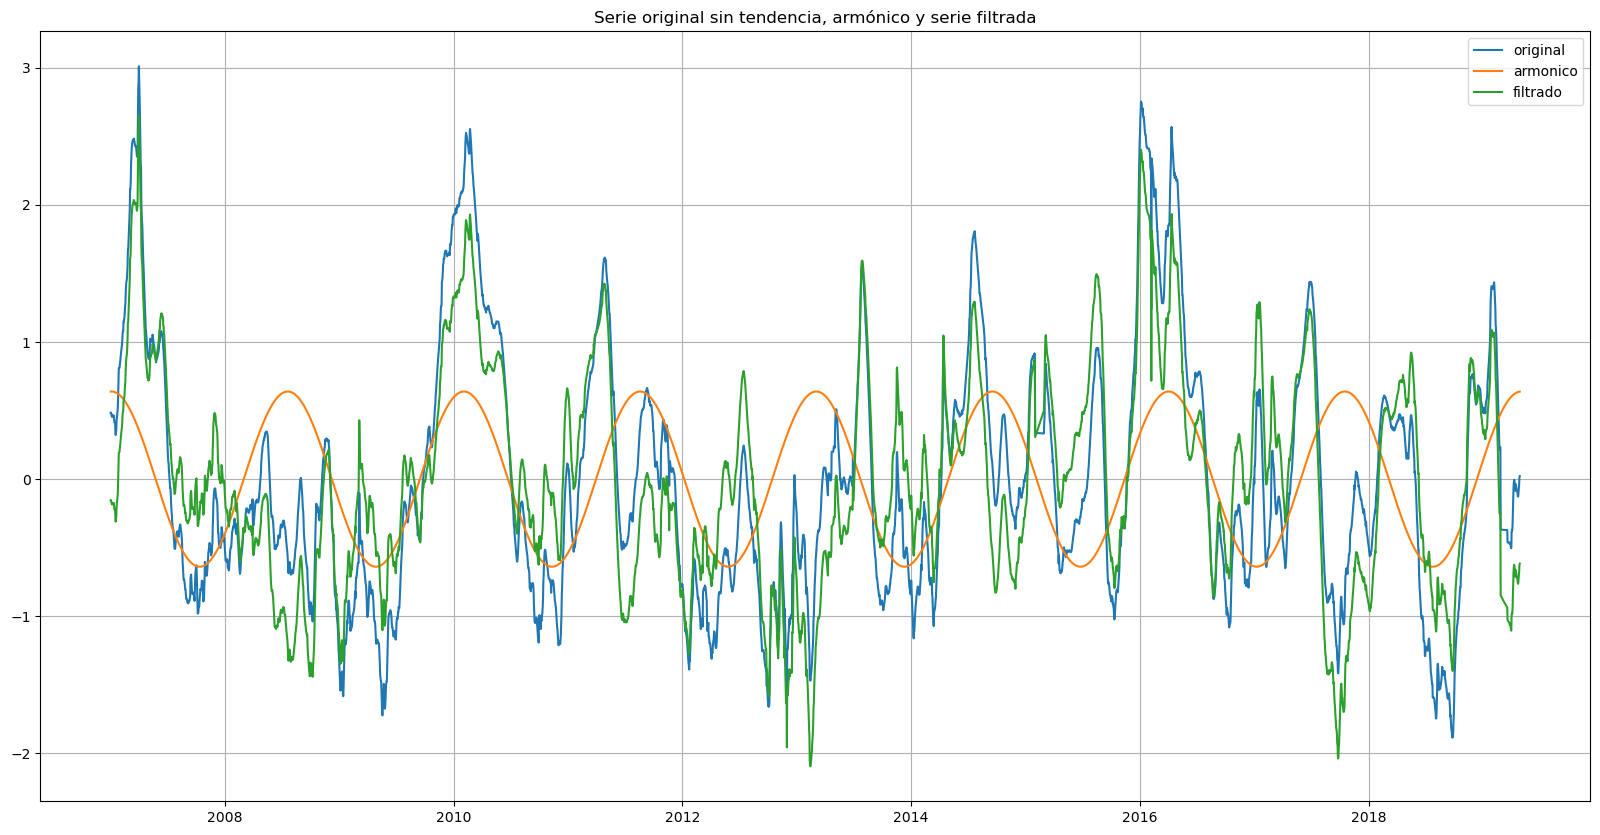

In [244]:
plt.figure(figsize=(20,10))
plt.plot(resultado)
plt.title('Serie original sin tendencia, armónico y serie filtrada')
plt.legend(['original','armonico','filtrado'])
plt.grid()

In [443]:
resultado

,original,armonico,filtrado
2007-01-01,0.484520,0.638529,-0.154009
2007-01-02,0.484361,0.638719,-0.154358
2007-01-03,0.474203,0.638830,-0.164627
2007-01-04,0.464045,0.638861,-0.174816
2007-01-05,0.453887,0.638812,-0.184926
...,...,...,...
2019-04-25,-0.097326,0.636385,-0.733711
2019-04-26,-0.057484,0.636973,-0.694457
2019-04-27,-0.037643,0.637481,-0.675124
2019-04-28,0.012199,0.637910,-0.625711


In [449]:
altura_de_rio_sin_tendencia_ni_octavo_armonico = resultado[['filtrado']]
altura_de_rio_sin_tendencia_ni_octavo_armonico.to_csv(path+'alturaderiosintendencianioctavoarmonico.csv')

In [454]:
df_altura = resultado[['filtrado']]
df_altura.columns = ['altura']
da_altura = xr.DataArray(df_altura['altura'], coords=[df_altura.index],dims=['time'])
ds_altura = xr.Dataset({'santotome': da_altura},
                      coords={'time': (df_altura.index)},
                      )
ds_altura

<xarray.Dataset>
Dimensions:    (time: 4502)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2019-04-29
Data variables:
    santotome  (time) float64 -0.154 -0.1544 -0.1646 ... -0.6751 -0.6257 -0.6162

In [ ]:
ds_altura.to_netcdf()

In [47]:
residual = pd.DataFrame(santotome_sin_tendencia).reset_index()
residual.columns = ['tiempo', 'valor']
residual

,tiempo,valor
0,2007-01-01,0.484520
1,2007-01-02,0.484361
2,2007-01-03,0.474203
3,2007-01-04,0.464045
4,2007-01-05,0.453887
...,...,...
4498,2019-04-26,-0.057484
4499,2019-04-27,-0.037643
4500,2019-04-28,0.012199
4501,2019-04-29,0.022041


In [91]:
santotome = santotome.reset_index()
santotome.columns = ['fecha', 'valor']
santotome

,fecha,valor
0,2007-01-01,3.82
1,2007-01-02,3.82
2,2007-01-03,3.81
3,2007-01-04,3.80
4,2007-01-05,3.79
...,...,...
4498,2019-04-26,3.99
4499,2019-04-27,4.01
4500,2019-04-28,4.06
4501,2019-04-29,4.07


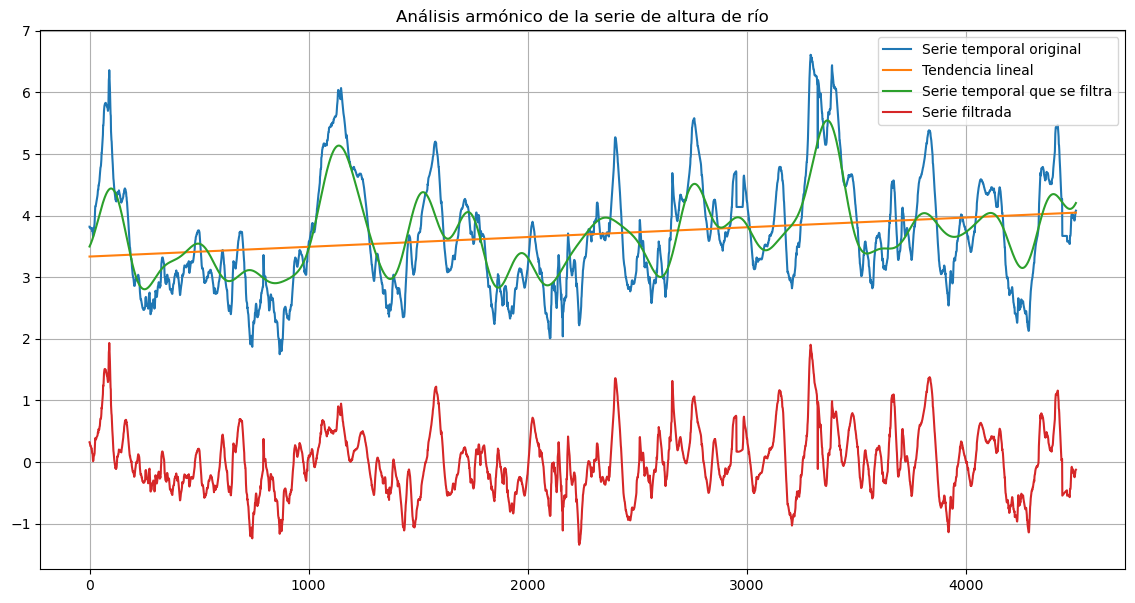

In [211]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Importar los datos de la serie temporal
data = santotome

# # Obtener el tiempo y los valores de la serie
t = data.index.values
y = data["valor"].values

# Calcular la regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(t, y)


# Calcular la señal de la tendencia lineal
trend = slope * t + intercept

# Calcular el residuo de la serie temporal después de la regresión lineal
residual = y - trend

# Calcular el espectro de la serie temporal
frequencies, power_spectrum = signal.periodogram(residual, fs=1/(t[1]-t[0]), scaling='spectrum')

#defino cantidad de armónicos
n_harmonics = 100

#defino un umbral de significancia
mean_power = np.mean(power_spectrum)
std_power = np.std(power_spectrum)
threshold = mean_power + 3*std_power  # Usamos un umbral de 3 desviaciones estándar

# Identificar los armónicos más significativos
significant_harmonics = []
for i in range(len(power_spectrum)):
    if power_spectrum[i] > threshold:
        significant_harmonics.append(i)
    if len(significant_harmonics) >= n_harmonics:
        break

# Filtrar la serie temporal utilizando los armónicos más significativos
filtered_signal = np.zeros_like(residual)
for i in significant_harmonics:
    amplitude = np.sqrt(power_spectrum[i])
    phase = np.angle(np.fft.fft(residual)[i])
    filtered_signal += amplitude * np.cos(2*np.pi*frequencies[i]*t + phase)

# Sumar la tendencia lineal y la serie temporal filtrada
filtered_series = trend + filtered_signal

serie_filtrada = y - filtered_signal - trend
# Graficar la serie temporal original, la tendencia lineal y la serie temporal filtrada
plt.figure(figsize=(14,7))
plt.title('Análisis armónico de la serie de altura de río')
plt.plot(t, y, label="Serie temporal original")
plt.plot(t, trend, label="Tendencia lineal")
plt.plot(t, filtered_series, label="Serie temporal que se filtra")
plt.plot(t, serie_filtrada, label="Serie filtrada")
plt.grid()
plt.legend(loc=0)
plt.show()


In [212]:
significant_harmonics

[2, 3, 4, 6, 8, 10, 11, 12, 14, 17, 19, 22]

In [ ]:
1/dia * K-esimo armónico: 